In [1]:
import polars as pl

# Scan the big parquet file and tot up the proportions of the winners
df_counts = (
    pl.scan_parquet("results.parquet")
    .group_by("monkey_strategy", "wolf_strategy")
    .agg(pl.col("winner").value_counts(normalize=True))
    .explode("winner")
    .unnest("winner")
    .collect()
)
df_counts

monkey_strategy,wolf_strategy,winner,proportion
str,str,str,f64
"""metric_count""","""metric_strength""","""monkey""",0.451
"""metric_count""","""metric_strength""","""wolf""",0.549
"""random_spot_win""","""metric_position""","""wolf""",0.7
"""random_spot_win""","""metric_position""","""monkey""",0.3
"""random_spot_win""","""random_spot_win""","""wolf""",0.438
…,…,…,…
"""metric_count""","""metric_position""","""wolf""",0.268
"""metric_strength""","""metric_count""","""monkey""",0.579
"""metric_strength""","""metric_count""","""wolf""",0.421


In [2]:
strategies = sorted(pl.concat(df_counts.select("monkey_strategy", "wolf_strategy")).unique())
strategies

['metric_count',
 'metric_position',
 'metric_strength',
 'random',
 'random_spot_win']

In [3]:
from collections import defaultdict

analysis_by_strategy: dict[str, pl.DataFrame] = {}

for strategy_a in strategies:
    data = defaultdict(list)
    for strategy_b in strategies:
        monkey_row = df_counts.filter(
            pl.col("monkey_strategy") == strategy_a,
            pl.col("wolf_strategy") == strategy_b,
            pl.col("winner") == "monkey",
        )
        assert monkey_row.height == 1
        monkey_proportion = monkey_row["proportion"][0]
        
        wolf_row = df_counts.filter(
            pl.col("wolf_strategy") == strategy_a,
            pl.col("monkey_strategy") == strategy_b,
            pl.col("winner") == "wolf",
        )
        assert wolf_row.height == 1
        wolf_proportion = wolf_row["proportion"][0]
        
        data["vs"].append(strategy_b)
        data["m"].append(monkey_proportion)
        data["w"].append(wolf_proportion)
    
    print(strategy_a)
    df = pl.DataFrame(data=data)
    print(df)
    analysis_by_strategy[strategy_a] = df

metric_count
shape: (5, 3)
┌─────────────────┬───────┬───────┐
│ vs              ┆ m     ┆ w     │
│ ---             ┆ ---   ┆ ---   │
│ str             ┆ f64   ┆ f64   │
╞═════════════════╪═══════╪═══════╡
│ metric_count    ┆ 0.52  ┆ 0.48  │
│ metric_position ┆ 0.732 ┆ 0.691 │
│ metric_strength ┆ 0.451 ┆ 0.421 │
│ random          ┆ 0.939 ┆ 0.919 │
│ random_spot_win ┆ 0.883 ┆ 0.836 │
└─────────────────┴───────┴───────┘
metric_position
shape: (5, 3)
┌─────────────────┬───────┬───────┐
│ vs              ┆ m     ┆ w     │
│ ---             ┆ ---   ┆ ---   │
│ str             ┆ f64   ┆ f64   │
╞═════════════════╪═══════╪═══════╡
│ metric_count    ┆ 0.309 ┆ 0.268 │
│ metric_position ┆ 0.544 ┆ 0.456 │
│ metric_strength ┆ 0.233 ┆ 0.198 │
│ random          ┆ 0.931 ┆ 0.876 │
│ random_spot_win ┆ 0.796 ┆ 0.7   │
└─────────────────┴───────┴───────┘
metric_strength
shape: (5, 3)
┌─────────────────┬───────┬───────┐
│ vs              ┆ m     ┆ w     │
│ ---             ┆ ---   ┆ ---   │
│ str        

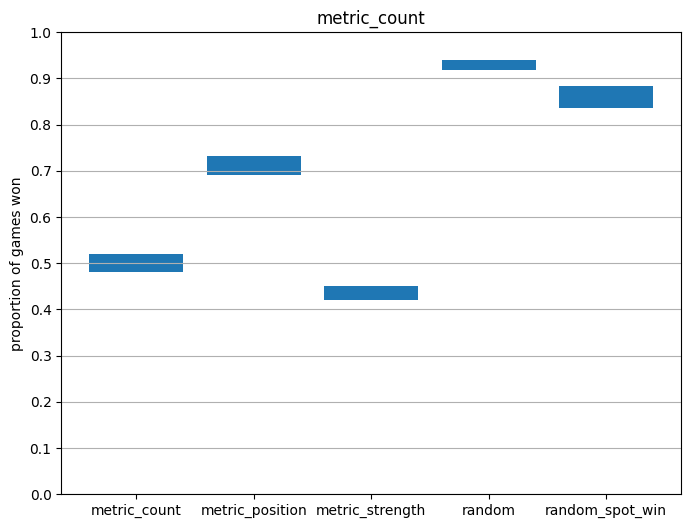

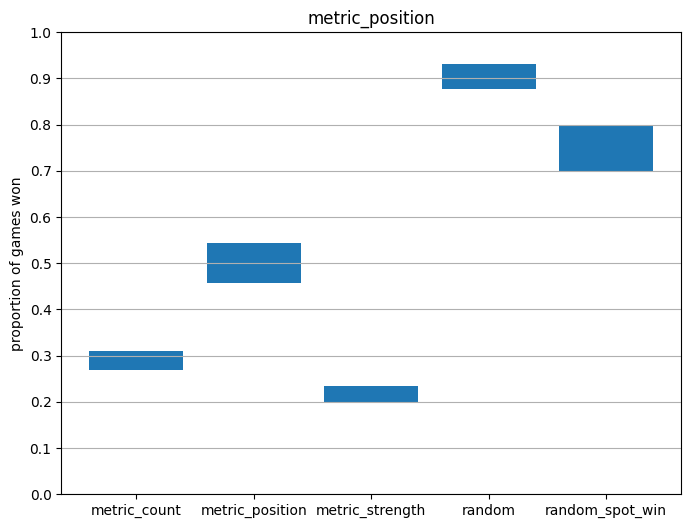

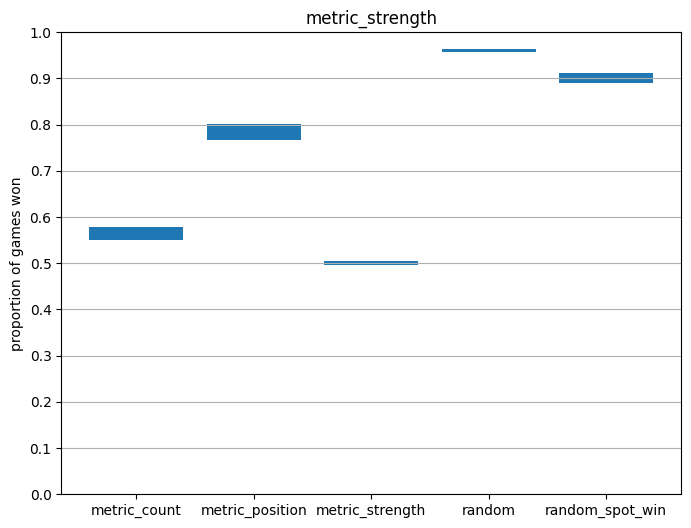

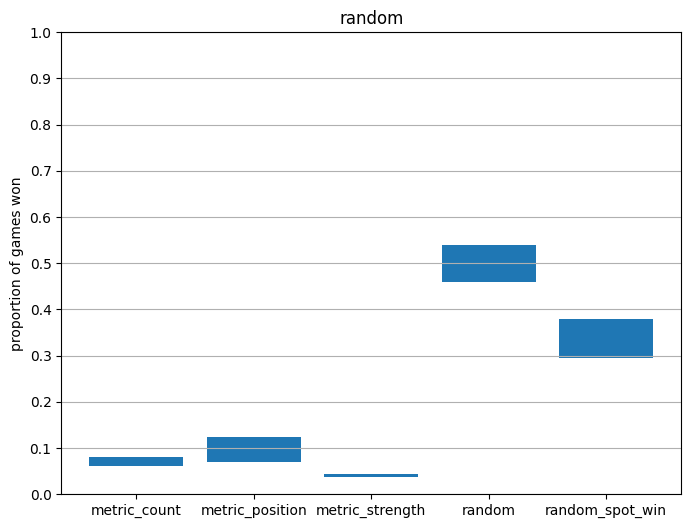

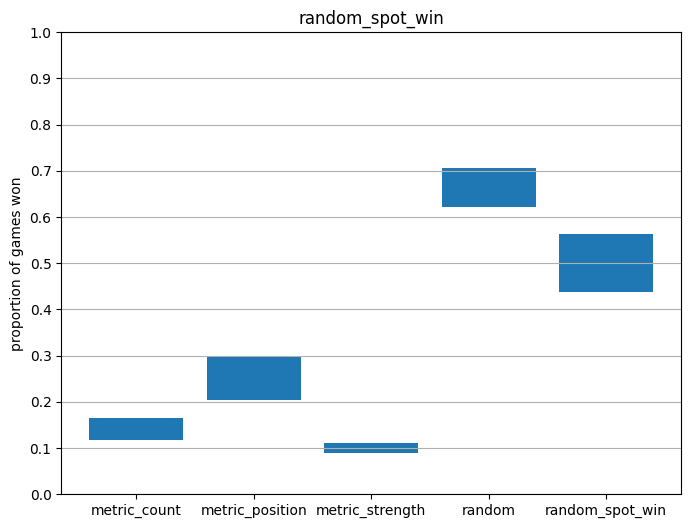

In [4]:
import matplotlib.pyplot as plt


def plot_bar_chart(strategy: str, df: pl.DataFrame) -> None:
    heights = (df["m"] - df["w"]).abs()
    bottom = df.select(pl.min_horizontal("m", "w")).to_series(0)
    
    plt.figure(figsize=(8, 6))
    plt.bar(
        x=df["vs"],
        height=heights,
        bottom=bottom,
    )
    
    plt.ylabel("proportion of games won")
    plt.title(strategy)
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.show()


for name, frame in analysis_by_strategy.items():
    plot_bar_chart(name, frame)